<a href="https://colab.research.google.com/github/CurtCalledBurt/DS-Unit-2-Kaggle-Challenge/blob/master/module4/assignment_kaggle_challenge_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 4

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 60% accuracy (above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](https://towardsdatascience.com/maximizing-scarce-maintenance-resources-with-data-8f3491133050), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading
- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Simple guide to confusion matrix terminology](https://www.dataschool.io/simple-guide-to-confusion-matrix-terminology/) by Kevin Markham, with video
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)
- [ ] Stacking Ensemble. (See below)

### Stacking Ensemble

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train_val = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [3]:
train, val = train_test_split(train_val, random_state=2019)
train.shape, val.shape, test.shape

((44550, 41), (14850, 41), (14358, 40))

In [0]:
target = 'status_group'
features = train_val.columns.drop([target])

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]

In [0]:
# Tanzania's max and min longitude and latitude never cross zero


should_not_have_zeroes_or_close_to_zeroes = ['amount_tsh', 'longitude', 
                                             'latitude', 'num_private',
                                             'construction_year']

should_nots = should_not_have_zeroes_or_close_to_zeroes

def wrangle(data):
  import numpy as np
  import pandas as pd
  
  # Prevents 'SettingWithCopyWarning' whatever that is
  data = data.copy()
  
  # input NaN's instead of zeroes and close to zero values where there should be NaN's
  for col in should_not_have_zeroes_or_close_to_zeroes:
    data[col] = np.where(data[col].between(-0.0001, 0.0001), np.nan, data[col])
  
  # convert days of year to datetime
  data['date_recorded'] = pd.to_datetime(data['date_recorded'])
  #OrdinalEncoder seems to not like datetime, so we drop all information except the year of date_recorded
  data['date_recorded'] = data['date_recorded'].dt.year
  
  # creat a feature of time between last inspection and construction
  data['time_between_inspections'] = data['date_recorded'] - data['construction_year']
  
  return(data)

In [0]:
X_train = wrangle(X_train)
X_val = wrangle(X_val)
X_test = wrangle(X_test)

In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce

In [14]:
%%time

pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=150, random_state=2019, n_jobs=-1)
)

# fit the model to the data
pipeline.fit(X_train, y_train)

CPU times: user 28.1 s, sys: 120 ms, total: 28.2 s
Wall time: 14.9 s


In [15]:
# get scores
print('Train Accuracy: ', pipeline.score(X_train, y_train))
print('Val Accuracy: ', pipeline.score(X_val, y_val))

#make prediction on the val
y_val_pred = pipeline.predict(X_val)

#make a prediction on the test
y_pred = pipeline.predict(X_test)

Train Accuracy:  0.9999775533108867
Val Accuracy:  0.8122558922558922


In [0]:
# generate submission

# estimator is your model or pipeline, which you've fit on X_train

# X_test is your pandas dataframe or numpy array, 
# with the same number of rows, in the same order, as test_features.csv, 
# and the same number of columns, in the same order, as X_train

# Makes a dataframe with two columns, id and status_group, 
# and writes to a csv file, without the index
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('Curtis-McKendrick-Pipes-RandomForest.csv', index=False)

In [16]:
# we now have a model and predictions with which to plot a confustion matrix

from sklearn.metrics import confusion_matrix

confusion_matrix(y_val, y_val_pred)

array([[7342,  162,  621],
       [ 599,  336,  143],
       [1179,   84, 4384]])

In [17]:
# now we make a nicer one with labels

from sklearn.utils.multiclass import unique_labels
unique_labels(y_val)

array(['functional', 'functional needs repair', 'non functional'],
      dtype='<U23')

In [27]:
labels = unique_labels(y_val_pred)
columns = [f'Predicted {label}' for label in labels]
rows = [f'Actual {label}' for label in labels]
table = pd.DataFrame(confusion_matrix(y_val, y_val_pred),
                    columns=columns, index=rows)
table

,Predicted functional,Predicted functional needs repair,Predicted non functional
Actual functional,7342,162,621
Actual functional needs repair,599,336,143
Actual non functional,1179,84,4384


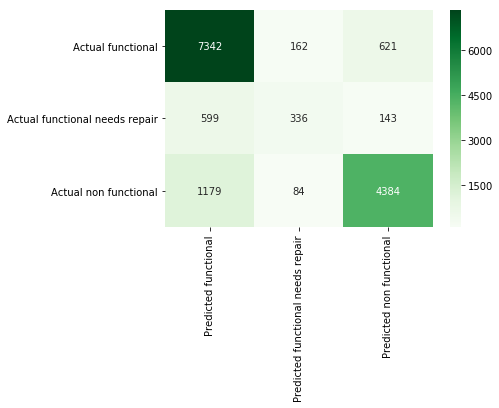

In [40]:
import seaborn as sns

sns.heatmap(table, fmt='d', annot=True, cmap='Greens');
# fmt='d' makes the numbers not be in scientific notation
# annot=True puts the numbers directly on the squares
# cmap selects the color pallat the heat map uses

In [0]:
y_train_non_func = y_train != 'functional'
y_val_non_func = y_val != 'functional'

In [44]:
pipeline.fit(X_train, y_train_non_func);

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['funder', 'installer', 'wpt_name',
                                      'basin', 'subvillage', 'region', 'lga',
                                      'ward', 'public_meeting', 'recorded_by',
                                      'scheme_management', 'scheme_name',
                                      'permit', 'extraction_type',
                                      'extraction_type_group',
                                      'extraction_type_class', 'management',
                                      'management_group', 'payment',
                                      'payment_type', 'water_qual...
                 RandomForestClassifier(bootstrap=True, class_weight=None,
                                        criterion='gini', max_depth=None,
                                        max_features='auto',
                                        max_leaf_nodes=None,
                       

In [0]:
y_pred_non_func = pipeline.predict(X_val)

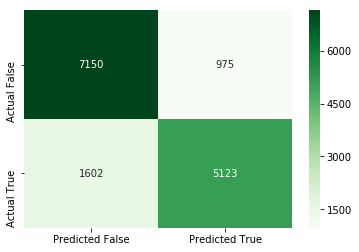

In [48]:
labels = unique_labels(y_pred_non_func)
columns = [f'Predicted {label}' for label in labels]
rows = [f'Actual {label}' for label in labels]
table = pd.DataFrame(confusion_matrix(y_val_non_func, y_pred_non_func),
                    columns=columns, index=rows)
table

sns.heatmap(table, fmt='d', annot=True, cmap='Greens');

In [0]:
probabilities = pipeline.predict_proba(X_val)
probabilities

y_pred_proba = probabilities[:, 1]

In [52]:
y_pred_non_func

array([ True, False, False, ...,  True, False,  True])

In [77]:
threshold = .94
probabilities[:, 1] > threshold

array([False, False, False, ..., False, False, False])

array([ True,  True,  True, ...,  True,  True,  True])

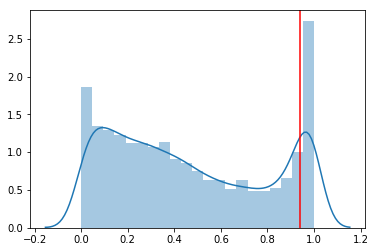

In [79]:
ax = sns.distplot(probabilities[:, 1])
ax.axvline(threshold, color='red')
pd.Series(probabilities[:, 1] > threshold).value_counts()

y_pred_non_func[probabilities[:, 1] > threshold]

In [0]:
results = pd.DataFrame({'y_val': y_val_non_func, 'y_pred_proba': y_pred_proba})
top2000 = results.sort_values(by='y_pred_proba', ascending=False)[:2000]

In [84]:
top2000

,y_val,y_pred_proba
32289,True,1.000000
40379,True,1.000000
37351,True,1.000000
9773,True,1.000000
35823,True,1.000000
23193,True,1.000000
5869,True,1.000000
6912,True,1.000000
54062,True,1.000000
55934,True,1.000000


In [86]:
top2000['y_val'].sum()

1985

In [89]:
print ('Accuracy: ', top2000['y_val'].sum()/2000 )

Accuracy:  0.9925
